In [1]:
import sys

sys.path.append("..")

from utilities import *
from catboost import CatBoostRegressor, Pool

warnings.filterwarnings("ignore")

raw_data = pd.read_excel("../data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

data = sa.data

data['date'] = pd.to_datetime(data['date'])

data = data[
    data["brand"].isin(["brand-35", "brand-14", "brand-15"])
] # Filtramos las 3 brands principales únicamente

# Crear series_id combinando brand + supermarket + variant + pack_size
data['series_id'] = (
    data['brand'].astype(str) + '_' + 
    data['supermarket'].astype(str) + '_' + 
    data['variant'].astype(str) + '_' + 
    data['pack.size'].astype(str)
)
data = data.sort_values(['series_id', 'date']).reset_index(drop=True)

/Users/oscarjimenezbou/Documents/TFG_ADE/code_new_models/TFG/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Create test_data and train_data

In [16]:
if False:
    _date_min = data["date"].min()
    _date_max = data["date"].max()
    _date_cutoff = pd.Timestamp('2023-06-30')

    train_data = data[data['date'] <= _date_cutoff].copy()
    test_data = data[(data['date'] >= _date_cutoff + pd.Timedelta(days=1)) & (data['date'] <= _date_max)].copy()

    print(f"Total de datos: {len(data)}")
    print(f"Train: {len(train_data)} filas, desde {train_data['date'].min()} hasta {train_data['date'].max()}")
    print(f"Test: {len(test_data)} filas, desde {test_data['date'].min()} hasta {test_data['date'].max()}")


2021-01-31 00:00:00 2023-12-31 00:00:00
Total de datos: 3403
Train: 2814 filas, desde 2021-01-31 00:00:00 hasta 2023-06-30 00:00:00
Test: 589 filas, desde 2023-07-31 00:00:00 hasta 2023-12-31 00:00:00


#### Check incomplete series data

In [3]:
def series_less_than_36(data: pd.DataFrame, months: int = 36) -> pd.DataFrame:
    """
    Comprueba que series no tienen datos de los 3 años

    Parameters:
    data (pd.DataFrame): Dataframe con los datos

    Returns (pd.DataFrame):
    pd.DataFrame: Dataframe con las series con menos de 36 datos ordenadas por número de datos
    """
    date_min = data["date"].min()
    date_max = data["date"].max()

    # Comprabar que series no tienen datos de los 3 años
    result_df = pd.DataFrame(columns=["series_id", "length"])
    i = 0
    for series_id in data["series_id"].unique():
        series_data = data[data["series_id"] == series_id]
        if len(series_data) < months:
            result_df = pd.concat(
                [
                    result_df,
                    pd.DataFrame(
                        {"series_id": [series_id], "length": [len(series_data)]}
                    ),
                ],
                ignore_index=True,
            )
        else:
            i+=1
    print(f"Series con más de {months} datos: {i}, un {100*(len(data.series_id.unique())-len(result_df))/len(data.series_id.unique())} % del total")
    print(f"Series con menos de {months} datos: {len(result_df)}, un {100*len(result_df)/len(data.series_id.unique())} % del total")
    return result_df.sort_values(by="length").reset_index(drop=True)

series_less_than_36_df = series_less_than_36(data)
print(series_less_than_36_df.head())

Series con más de 36 datos: 67, un 59.29203539823009 % del total
Series con menos de 36 datos: 46, un 40.70796460176991 % del total
                                    series_id length
0   brand-14_supermarket-B_light_351 - 500 GR      5
1     brand-15_supermarket-C_light_0 - 350 GR      7
2  brand-35_supermarket-D_standard_0 - 350 GR      8
3     brand-35_supermarket-C_light_0 - 350 GR      8
4  brand-14_supermarket-A_vegan_701 - 1000 GR      8


In [4]:
_series_less_than_36_df_train_data = series_less_than_36(train_data, 30)
_series_less_than_36_df_test_data = series_less_than_36(test_data, 6)

Series con más de 30 datos: 72, un 63.716814159292035 % del total
Series con menos de 30 datos: 41, un 36.283185840707965 % del total
Series con más de 6 datos: 89, un 83.17757009345794 % del total
Series con menos de 6 datos: 18, un 16.822429906542055 % del total


# CatBoost

Creamos un calendario completo (para no saltarse meses con ninguna serie). 
Para la serie que no tiene valores en en esas fechas creadas. Se ponen en los datos NaN

In [5]:
all_months = pd.date_range(data["date"].min(), data["date"].max(), freq="ME")
uniques = pd.DataFrame({"series_id": data["series_id"].unique()})
all_months_df = pd.DataFrame({"date": all_months})
full = uniques.assign(_key=1).merge(all_months_df.assign(_key=1), on="_key").drop("_key", axis=1)
full = full.merge(data, on=["series_id", "date"], how="left")

In [6]:
_series = series_less_than_36(full)
print(_series.head())

Series con más de 36 datos: 113, un 100.0 % del total
Series con menos de 36 datos: 0, un 0.0 % del total
Empty DataFrame
Columns: [series_id, length]
Index: []


- creamos `was_missing` crea una bandera 1/0 diciendo si ese mes venía vacío en el Excel.
- rellenamos con 0 si en volume.sales falta valores
- En price:
  - si falta el precio en un mes, usa el último precio conocido hacia atrás
  - si aun así queda vacío (por ejemplo al inicio), lo rellena con la mediana global del precio.

Porque CatBoost no puede entrenar con NaN así sin más en todas las columnas. Y para los lags/rollings necesitas continuidad.

In [7]:
full["missing"] = full["volume.sales"].isna().astype(int)
full["volume.sales"] = full["volume.sales"].fillna(0.0)

full = full.sort_values(["series_id", "date"])
full["price"] = full.groupby("series_id")["price"].ffill()
full["price"] = full["price"].fillna(full["price"].median())

In [8]:
# transformamos la variable objetivo
full["y"] = np.log1p(full["volume.sales"])

In [9]:
# features de calendario
full["year"] = full["date"].dt.year
full["month"] = full["date"].dt.month
full["quarter"] = full["date"].dt.quarter

full["month_sin"] = np.sin(2*np.pi*full["month"]/12)
full["month_cos"] = np.cos(2*np.pi*full["month"]/12)

In [10]:
# creamos lags
def add_lags(panel, col, lags=(1,2,3,6,12)):
    for l in lags:
        panel[f"{col}_lag_{l}"] = panel.groupby("series_id")[col].shift(l)
    return panel

full = add_lags(full, "y")
full = add_lags(full, "price", lags=(1,))


In [11]:
# Crear medias móviles con shift(1) para evitar data leakage
full["y_roll_mean_3"] = full.groupby("series_id")["y"].shift(1).rolling(3, min_periods=1).mean().reset_index(level=0, drop=True)
full["y_roll_mean_6"] = full.groupby("series_id")["y"].shift(1).rolling(6, min_periods=1).mean().reset_index(level=0, drop=True)
full["y_roll_mean_12"] = full.groupby("series_id")["y"].shift(1).rolling(12, min_periods=1).mean().reset_index(level=0, drop=True)

In [12]:
full["price_change"] = full["price"] - full["price_lag_1"]

In [13]:
# define feature columns y target
feature_cols = (
    ["series_id"] 
    + ["price", "missing", "year", "month", "quarter", "month_sin", "month_cos"]
    + [c for c in full.columns if c.startswith("y_lag_") or c.startswith("price_lag_")]
    + ["y_roll_mean_3", "y_roll_mean_6", "y_roll_mean_12", "price_change"]
)

X = full[feature_cols]
y = full["y"]

cat_features = ["series_id"]

In [18]:
# ========= 7) Split temporal =========
cutoff = pd.Timestamp("2023-06-30")
train_idx = full["date"] <= cutoff
valid_idx = full["date"] > cutoff

X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_valid, y_valid = X.loc[valid_idx], y.loc[valid_idx]


In [ ]:
# creamos pools para que el modelo sepa que columnas son categóricas
train_pool = Pool(X_train, y_train, cat_features=cat_features)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)


In [20]:
model = CatBoostRegressor(
    loss_function="RMSE",
    iterations=5000,
    learning_rate=0.03,
    depth=8,
    random_seed=42,
    eval_metric="RMSE",
    verbose=200
)

model.fit(train_pool, eval_set=valid_pool, use_best_model=True)


0:	learn: 4.1355468	test: 3.9389295	best: 3.9389295 (0)	total: 62.5ms	remaining: 5m 12s
200:	learn: 0.7216974	test: 0.8859381	best: 0.8859381 (200)	total: 425ms	remaining: 10.2s
400:	learn: 0.5566548	test: 0.8751409	best: 0.8642195 (324)	total: 788ms	remaining: 9.04s
600:	learn: 0.4471351	test: 0.8842211	best: 0.8642195 (324)	total: 1.17s	remaining: 8.59s
800:	learn: 0.3837676	test: 0.8818590	best: 0.8642195 (324)	total: 1.53s	remaining: 8.05s
1000:	learn: 0.3349822	test: 0.8764549	best: 0.8642195 (324)	total: 1.9s	remaining: 7.59s
1200:	learn: 0.2939667	test: 0.8760689	best: 0.8642195 (324)	total: 2.26s	remaining: 7.16s
1400:	learn: 0.2598862	test: 0.8768201	best: 0.8642195 (324)	total: 2.63s	remaining: 6.75s
1600:	learn: 0.2312467	test: 0.8765327	best: 0.8642195 (324)	total: 2.99s	remaining: 6.35s
1800:	learn: 0.2078591	test: 0.8773240	best: 0.8642195 (324)	total: 3.36s	remaining: 5.97s
2000:	learn: 0.1868823	test: 0.8777598	best: 0.8642195 (324)	total: 3.73s	remaining: 5.58s
2200:	l

In [23]:
pred_log = model.predict(X_valid)
pred = np.expm1(pred_log)
real = full.loc[valid_idx, "volume.sales"]

mae = np.mean(np.abs(pred - real))
rmse = np.sqrt(np.mean((pred - real)**2))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 11203.80
RMSE: 28190.91


## Visualización de Predicciones

Se incluyen las siguientes visualizaciones:
1. **Gráfico agregado**: Predicciones vs valores reales sumados por fecha
2. **Scatter plot**: Predicciones vs valores reales con línea perfecta
3. **Distribución de errores**: Histograma y box plots por serie
4. **Series individuales**: Visualización de 6 series representativas
5. **Resumen de métricas**: Estadísticas por serie


In [24]:
# Crear DataFrame con predicciones y valores reales para visualización
results_df = full.loc[valid_idx, ["series_id", "date", "volume.sales"]].copy()
results_df["predicted"] = pred
results_df["real"] = real
results_df["error"] = pred - real
results_df["abs_error"] = np.abs(pred - real)
results_df["pct_error"] = np.abs(pred - real) / (real + 1) * 100  # +1 para evitar división por cero


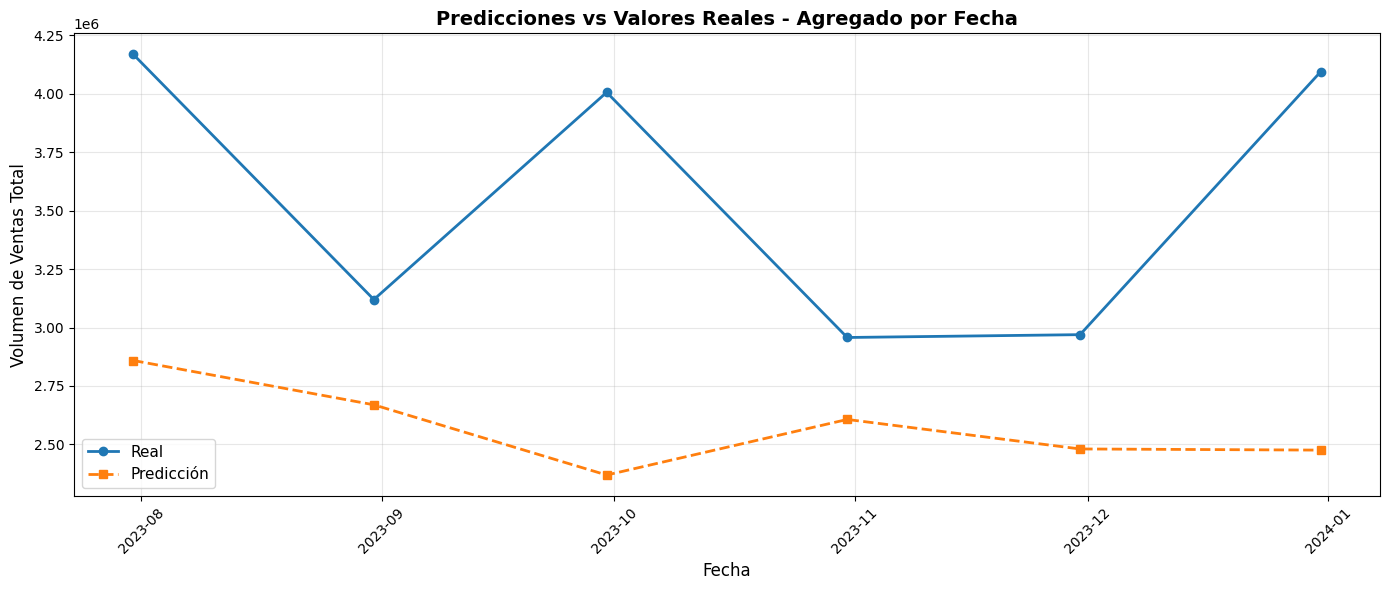

In [25]:
# 1. Gráfico agregado: Predicciones vs Reales por fecha (suma de todas las series)
agg_by_date = results_df.groupby("date").agg({
    "predicted": "sum",
    "real": "sum"
}).reset_index()

plt.figure(figsize=(14, 6))
plt.plot(agg_by_date["date"], agg_by_date["real"], label="Real", marker="o", linewidth=2)
plt.plot(agg_by_date["date"], agg_by_date["predicted"], label="Predicción", marker="s", linewidth=2, linestyle="--")
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Volumen de Ventas Total", fontsize=12)
plt.title("Predicciones vs Valores Reales - Agregado por Fecha", fontsize=14, fontweight="bold")
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


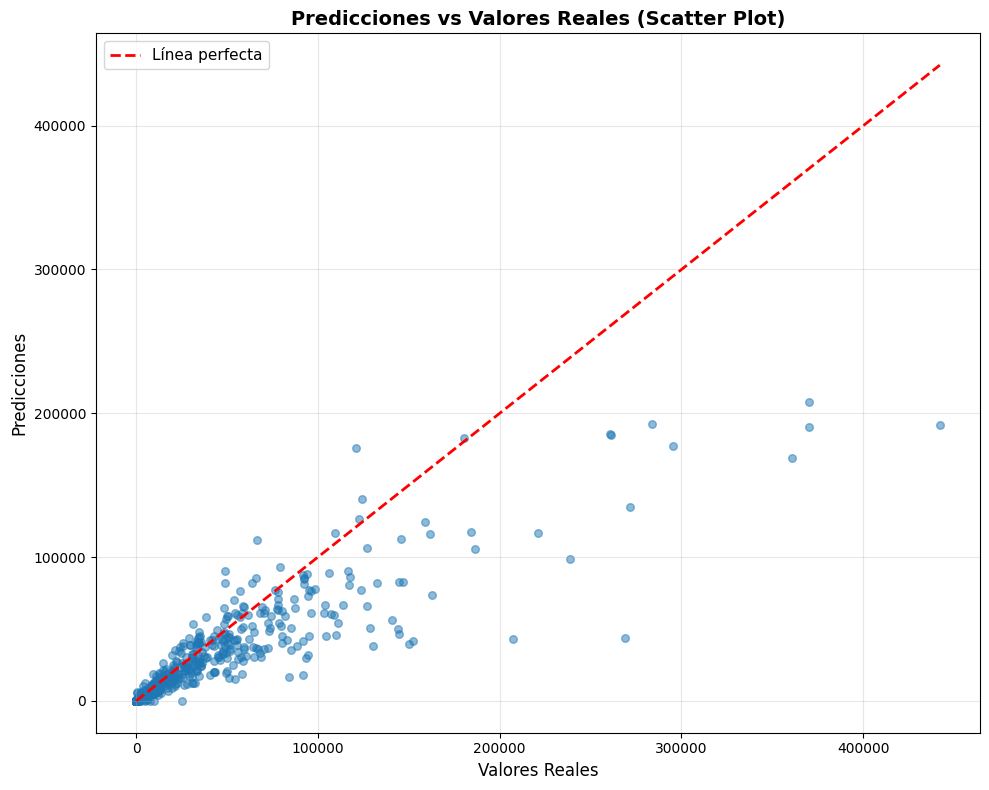

R² Score: 0.7058


In [26]:
# 2. Scatter plot: Predicciones vs Valores Reales
plt.figure(figsize=(10, 8))
plt.scatter(real, pred, alpha=0.5, s=30)
plt.plot([real.min(), real.max()], [real.min(), real.max()], 'r--', lw=2, label='Línea perfecta')
plt.xlabel("Valores Reales", fontsize=12)
plt.ylabel("Predicciones", fontsize=12)
plt.title("Predicciones vs Valores Reales (Scatter Plot)", fontsize=14, fontweight="bold")
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calcular R²
from sklearn.metrics import r2_score
r2 = r2_score(real, pred)
print(f"R² Score: {r2:.4f}")


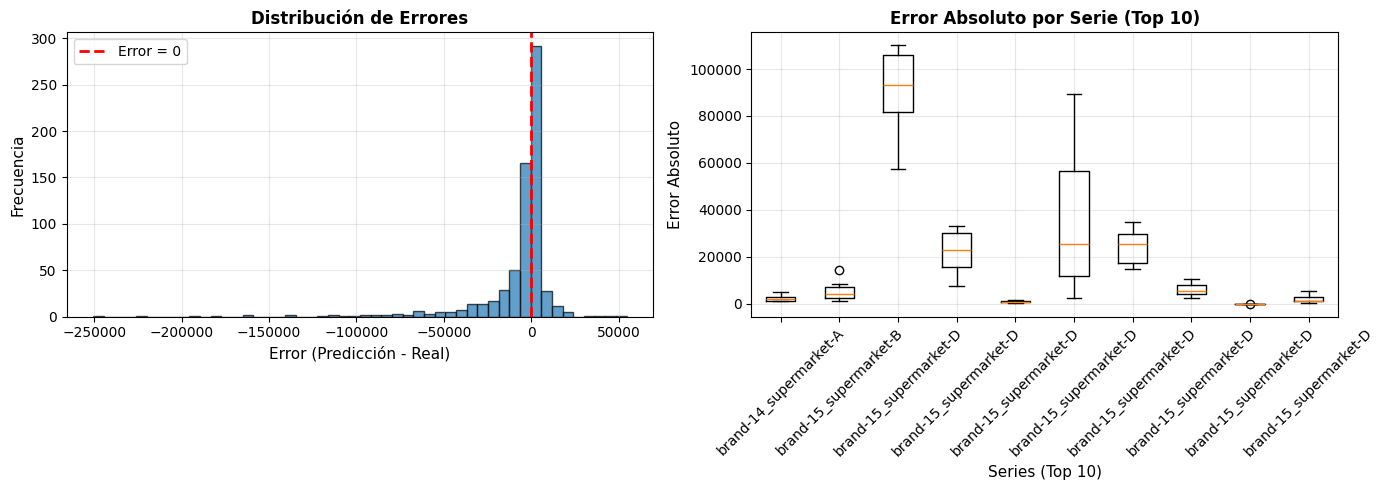

In [27]:
# 3. Distribución de errores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de errores
axes[0].hist(results_df["error"], bins=50, edgecolor="black", alpha=0.7)
axes[0].axvline(x=0, color="r", linestyle="--", linewidth=2, label="Error = 0")
axes[0].set_xlabel("Error (Predicción - Real)", fontsize=11)
axes[0].set_ylabel("Frecuencia", fontsize=11)
axes[0].set_title("Distribución de Errores", fontsize=12, fontweight="bold")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot de errores absolutos por serie (top 10 series con más datos)
top_series = results_df.groupby("series_id").size().sort_values(ascending=False).head(10).index
top_series_data = results_df[results_df["series_id"].isin(top_series)]
axes[1].boxplot([top_series_data[top_series_data["series_id"] == s]["abs_error"].values 
                 for s in top_series], 
                labels=[s.split("_")[0] + "_" + s.split("_")[1] for s in top_series],
                vert=True)
axes[1].set_ylabel("Error Absoluto", fontsize=11)
axes[1].set_xlabel("Series (Top 10)", fontsize=11)
axes[1].set_title("Error Absoluto por Serie (Top 10)", fontsize=12, fontweight="bold")
axes[1].tick_params(axis="x", rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


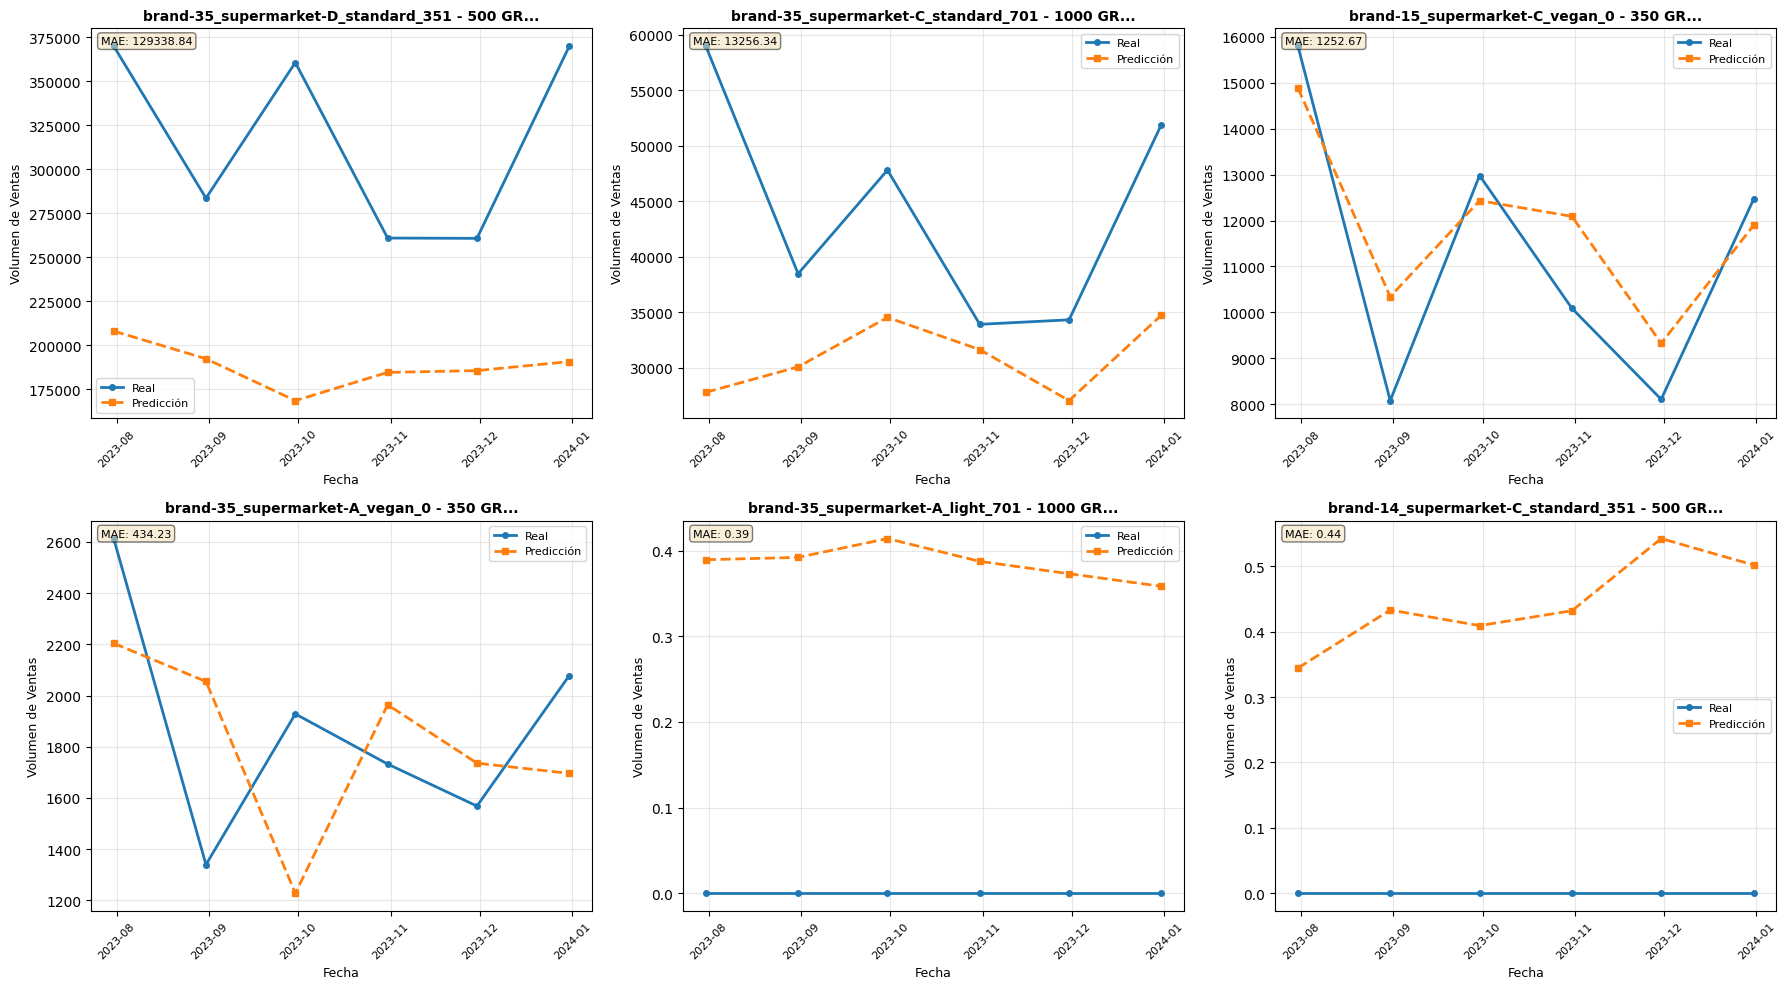

In [28]:
# 4. Visualización de algunas series individuales representativas
# Seleccionar algunas series con diferentes niveles de ventas
series_stats = results_df.groupby("series_id").agg({
    "real": ["mean", "std", "count"]
}).reset_index()
series_stats.columns = ["series_id", "mean_sales", "std_sales", "count"]
series_stats = series_stats.sort_values("mean_sales", ascending=False)

# Seleccionar 6 series representativas: 2 con alto volumen, 2 con medio, 2 con bajo
n_series = min(6, len(series_stats))
selected_indices = [0, len(series_stats)//4, len(series_stats)//2, 
                    3*len(series_stats)//4, len(series_stats)-2, len(series_stats)-1]
selected_series = series_stats.iloc[selected_indices]["series_id"].values

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, series_id in enumerate(selected_series[:6]):
    series_data = results_df[results_df["series_id"] == series_id].sort_values("date")
    
    axes[idx].plot(series_data["date"], series_data["real"], 
                   label="Real", marker="o", linewidth=2, markersize=4)
    axes[idx].plot(series_data["date"], series_data["predicted"], 
                   label="Predicción", marker="s", linewidth=2, linestyle="--", markersize=4)
    axes[idx].set_title(f"{series_id[:50]}...", fontsize=10, fontweight="bold")
    axes[idx].set_xlabel("Fecha", fontsize=9)
    axes[idx].set_ylabel("Volumen de Ventas", fontsize=9)
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis="x", rotation=45, labelsize=8)
    
    # Calcular métricas para esta serie
    series_mae = np.mean(np.abs(series_data["predicted"] - series_data["real"]))
    axes[idx].text(0.02, 0.98, f"MAE: {series_mae:.2f}", 
                   transform=axes[idx].transAxes, fontsize=8,
                   verticalalignment="top", bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

plt.tight_layout()
plt.show()


In [ ]:
# 5. Resumen de métricas por serie
metrics_by_series = results_df.groupby("series_id").agg({
    "real": "sum",
    "predicted": "sum",
    "abs_error": "mean",
    "pct_error": "mean"
}).reset_index()
metrics_by_series.columns = ["series_id", "total_real", "total_predicted", "mean_abs_error", "mean_pct_error"]
metrics_by_series["total_error"] = metrics_by_series["total_predicted"] - metrics_by_series["total_real"]
metrics_by_series = metrics_by_series.sort_values("mean_abs_error", ascending=False)

print("=" * 80)
print("RESUMEN DE MÉTRICAS POR SERIE")
print("=" * 80)
print(f"\nTop 10 series con mayor error absoluto medio:")
print(metrics_by_series.head(10)[["series_id", "mean_abs_error", "mean_pct_error"]].to_string(index=False))
print(f"\nTop 10 series con menor error absoluto medio:")
print(metrics_by_series.tail(10)[["series_id", "mean_abs_error", "mean_pct_error"]].to_string(index=False))
print(f"\nEstadísticas generales del error absoluto:")
print(f"  Media: {metrics_by_series['mean_abs_error'].mean():.2f}")
print(f"  Mediana: {metrics_by_series['mean_abs_error'].median():.2f}")
print(f"  Desviación estándar: {metrics_by_series['mean_abs_error'].std():.2f}")
print(f"\nEstadísticas generales del error porcentual:")
print(f"  Media: {metrics_by_series['mean_pct_error'].mean():.2f}%")
print(f"  Mediana: {metrics_by_series['mean_pct_error'].median():.2f}%")
print(f"  Desviación estándar: {metrics_by_series['mean_pct_error'].std():.2f}%")


RESUMEN DE MÉTRICAS POR SERIE

Top 10 series con mayor error absoluto medio:
                                    series_id  mean_abs_error  mean_pct_error
 brand-35_supermarket-D_standard_351 - 500 GR   129338.838990       39.280924
 brand-35_supermarket-A_standard_351 - 500 GR   122714.497715       59.657780
brand-15_supermarket-D_standard_701 - 1000 GR    96437.140331       34.422731
 brand-15_supermarket-D_standard_501 - 700 GR    90232.492024       65.646069
 brand-15_supermarket-C_standard_501 - 700 GR    50840.890684       75.322546
    brand-35_supermarket-D_light_351 - 500 GR    49422.552615       39.181017
brand-14_supermarket-D_standard_701 - 1000 GR    39449.822559       27.580398
   brand-15_supermarket-D_light_701 - 1000 GR    36049.887341       33.876166
 brand-35_supermarket-B_standard_351 - 500 GR    33353.463770       38.237991
 brand-15_supermarket-A_standard_501 - 700 GR    31914.244422       41.632818

Top 10 series con menor error absoluto medio:
                  